In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

# 12 Monsters and Mixtures

## 12.1 Over-dispersed counts

### 12.1.1 Beta-Binomial

Beta distributuion:

$$ x \sim beta(\bar{p}, \theta) $$


another parametrization:

$$ x \sim beta(\alpha, \beta) $$

where:
$$ \alpha = \bar{p} \theta $$

$$ \beta = (1 - \bar{p}) \theta$$

### R Code 12.1

In [57]:
def plot_beta(p_bar, theta):
    alpha = p_bar * theta
    beta = (1 - p_bar) * theta

    x = np.linspace(0, 1, num=100)

    plt.figure(figsize=(17, 5))

    plt.plot(x, stats.beta.pdf(x, alpha, beta))

    plt.title(f'Beta Distribution \n\n $alpha={round(alpha, 3)}$, $beta={round(beta, 3)}$ \n\n $pbar={p_bar}$, $theta={theta}$')
    plt.ylabel('Density')
    plt.xlabel('x')
    plt.show()

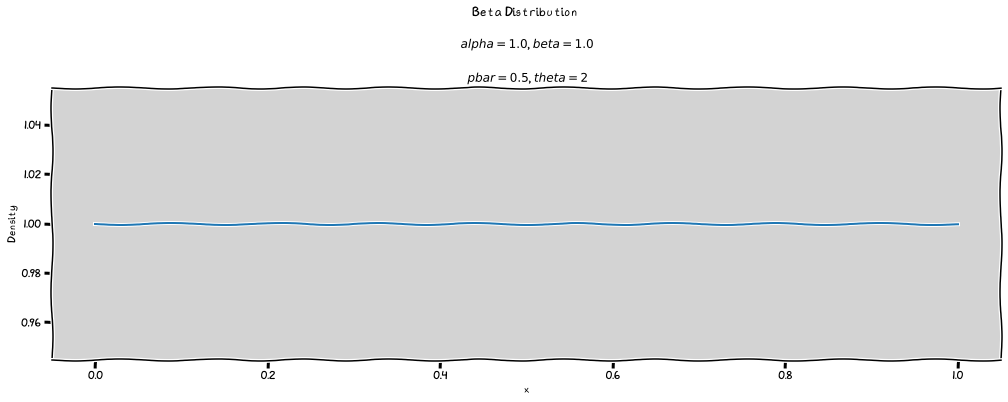

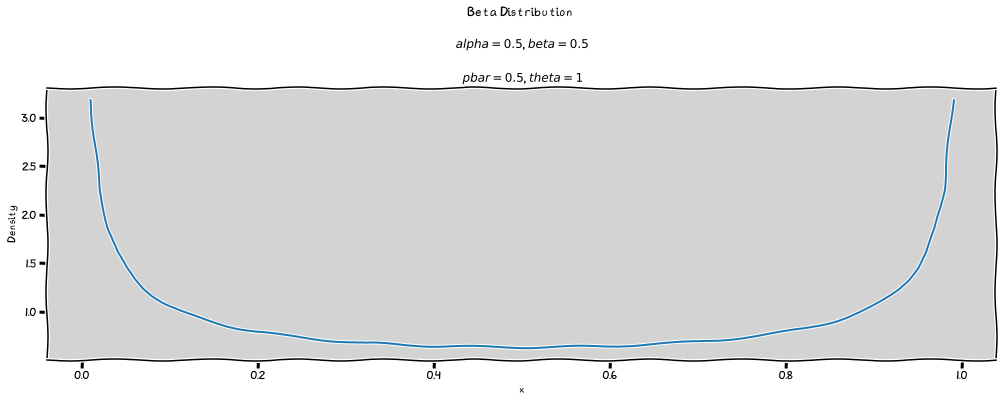

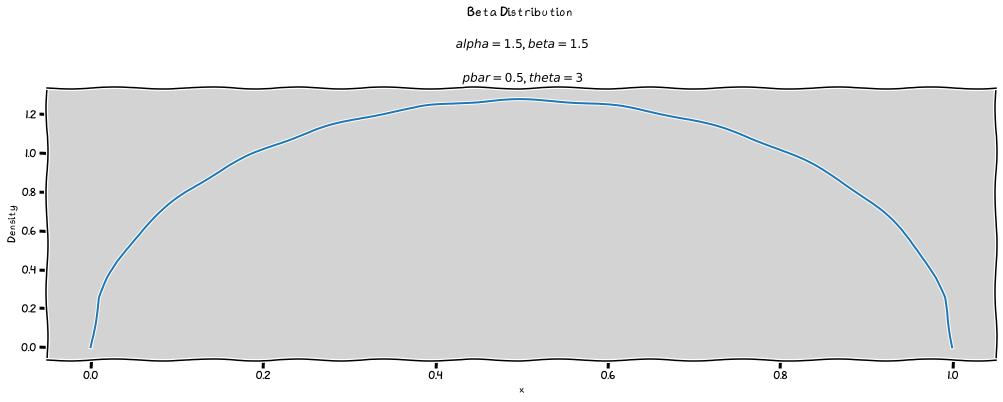

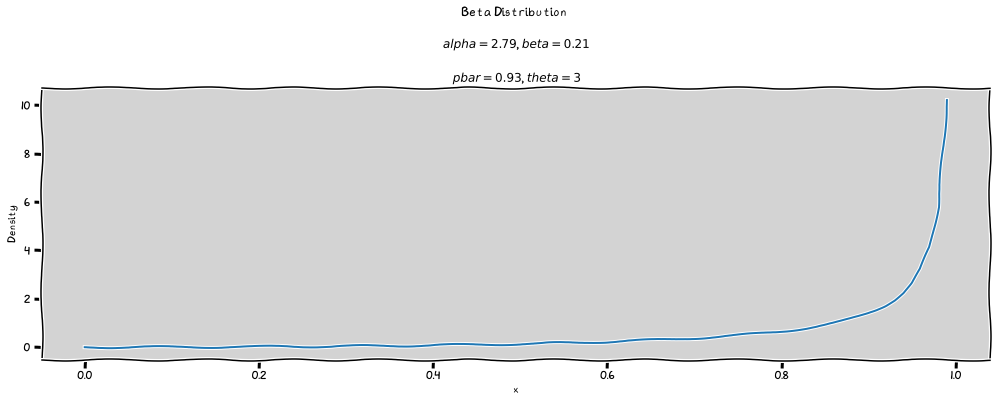

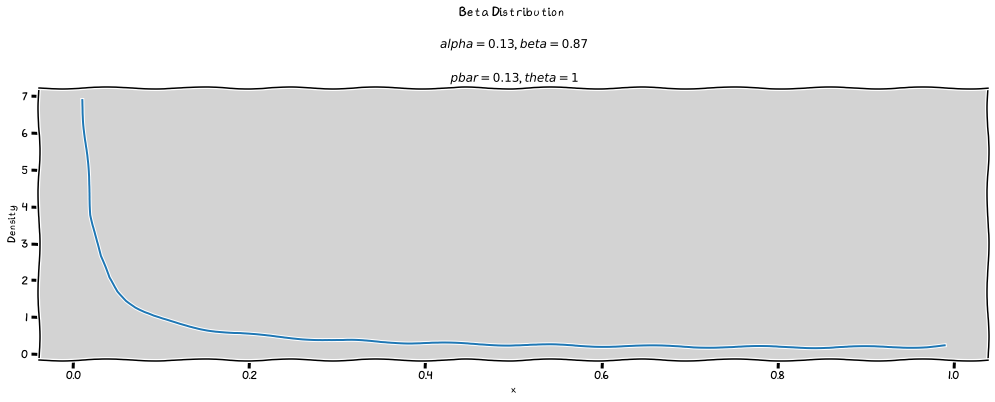

In [71]:
p_bar = 0.5
theta = 2
plot_beta(p_bar, theta)

# -----
p_bar = 0.5
theta = 1
plot_beta(p_bar, theta)

# -----
p_bar = 0.5
theta = 3
plot_beta(p_bar, theta)

# -----
p_bar = 0.93  # 0 < p < 1
theta = 3
plot_beta(p_bar, theta)

# -----
p_bar = 0.13  # 0 < p < 1
theta = 1
plot_beta(p_bar, theta)

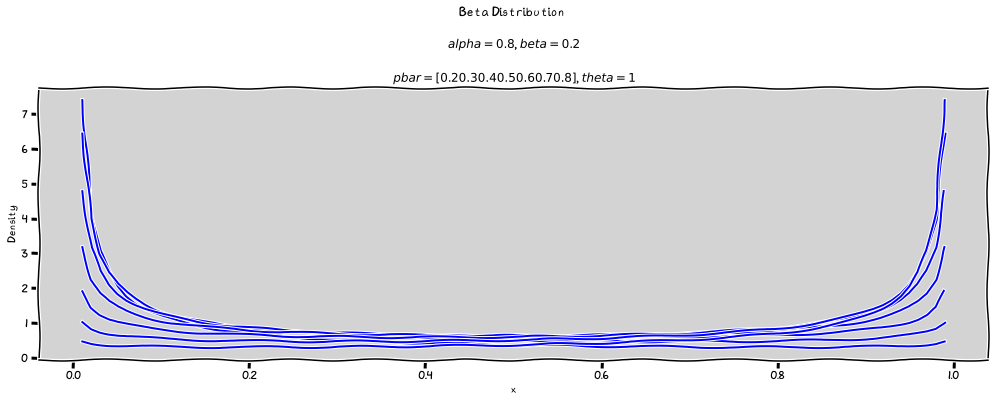

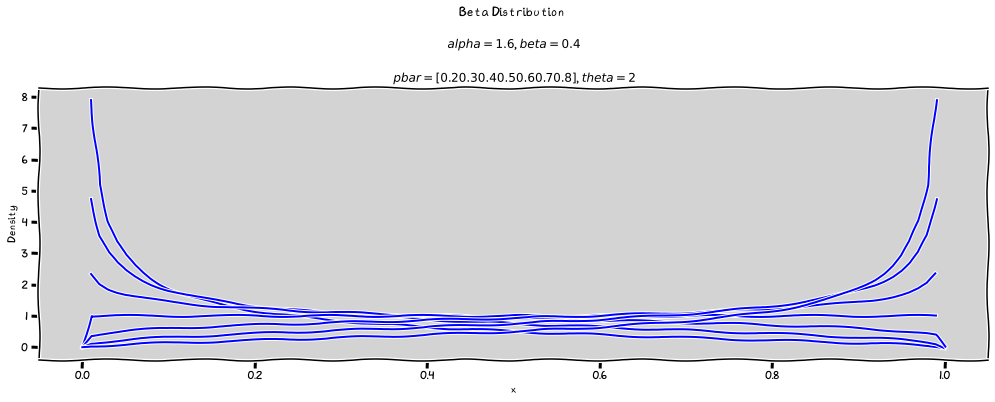

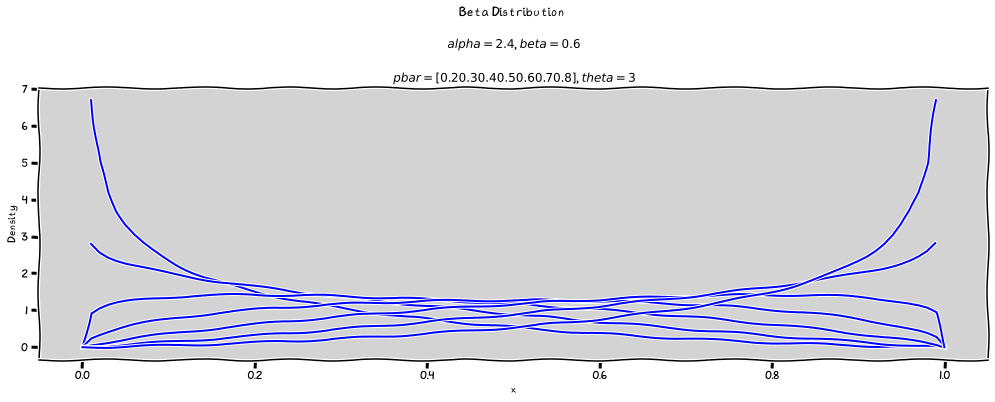

In [ ]:

p_bar = np.arange(0.2, 0.8, 0.1)  # array([0.2 , 0.3, ..., 0.8])
theta = [1, 2, 3]

x = np.linspace(0, 1, num=100)



for t in theta:
    plt.figure(figsize=(17, 5))
    for p in p_bar:
        alpha = p * t
        beta = (1 - p) * t

        plt.plot(x, stats.beta.pdf(x, alpha, beta), c='blue')

        plt.title(f'Beta Distribution \n\n $alpha={round(alpha, 3)}$, $beta={round(beta, 3)}$ \n\n $pbar={p_bar}$, $theta={round(t, 3)}$')
        plt.ylabel('Density')
        plt.xlabel('x')
    plt.show()